# Import Necessary Libraries

In [1]:
!pip install -q albumentations==0.5.2
import albumentations as A
A.__version__

'0.5.2'

In [2]:
import torch
torch.__version__

'1.11.0'

In [3]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [4]:
import torchvision
torchvision.__version__

'0.12.0'

In [5]:
!pip install -q pytorch_lightning
import pytorch_lightning as pl
print(pl.__version__)

1.9.0


# Create Dataset with Data Augmentation for Training

In [6]:
import os
import numpy as np
from PIL import Image
from torchvision import transforms
from xml.etree.ElementTree import parse
from albumentations.pytorch import ToTensor

In [7]:
class MaskDataset(torch.utils.data.Dataset):

    def __init__(self, root):
        self.root = root
        self.mask_labels = ['BG', 'without_mask', 'with_mask', 'mask_weared_incorrect']
        self.imgs = list(sorted(os.listdir('/kaggle/input/face-mask-detection/images/')))
        # Add for data augmentation
        bbox_params = A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels'])
        self.transform = A.Compose([
            A.HorizontalFlip(p = 0.1),
            A.VerticalFlip(p = 0.1),
            A.RandomBrightnessContrast(p = 0.1),
            ToTensor()
          ], bbox_params = bbox_params)

    def __getitem__(self, idx):
        data = 'maksssksksss' + str(idx)

        image_path = f'{self.root}/images/{data}.png'
        image = Image.open(image_path).convert('RGB')
        image = np.array(image)

        anno_path = f'{self.root}/annotations/{data}.xml'
        parser = parse(anno_path)
        labels, boxes = [], []
        for obj in parser.findall('object'):
            bndbox = obj.find('bndbox')
            if bndbox.find('xmin').text != bndbox.find('xmax').text: # Add
                box = [int(tag.text) for tag in obj.find('bndbox')]
                label = obj.find('name').text
                label = self.mask_labels.index(label)
                boxes.append(box)
                labels.append(label)
                
        transformed = self.transform(image = image, bboxes = boxes, class_labels = labels)
        image = transformed['image']
        boxes = torch.tensor(transformed['bboxes'], dtype = torch.float32)
        labels = torch.tensor(transformed['class_labels'], dtype = torch.int64)
        
        # Add for estimation of mean Average Precisions
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        image_id = torch.tensor([idx])
        iscrowd = torch.zeros((len(parser.findall('object')),), dtype = torch.int64)

        target = {'boxes': boxes, 'labels': labels, 'image_id': image_id, 'area': area, 'iscrowd': iscrowd}

        return image, target


    def __len__(self):
        return len(self.imgs)

In [8]:
pl.seed_everything(0)
root = '/kaggle/input/face-mask-detection'
dataset1 = MaskDataset(root)

In [9]:
len(dataset1)

853

In [10]:
x, t = dataset1[0]

In [11]:
x

tensor([[[0.4431, 0.4314, 0.3843,  ..., 0.1569, 0.2824, 0.3373],
         [0.4118, 0.3882, 0.3451,  ..., 0.1529, 0.1882, 0.3098],
         [0.3765, 0.3569, 0.3255,  ..., 0.1490, 0.1216, 0.2784],
         ...,
         [0.3333, 0.3412, 0.3569,  ..., 0.1098, 0.1098, 0.1137],
         [0.3373, 0.3490, 0.3608,  ..., 0.1137, 0.1137, 0.1176],
         [0.3647, 0.3765, 0.3922,  ..., 0.1176, 0.1176, 0.1216]],

        [[0.4353, 0.4235, 0.3765,  ..., 0.2314, 0.3843, 0.4549],
         [0.3922, 0.3804, 0.3373,  ..., 0.2275, 0.2863, 0.4275],
         [0.3608, 0.3412, 0.3098,  ..., 0.2235, 0.2235, 0.3922],
         ...,
         [0.3255, 0.3333, 0.3490,  ..., 0.1059, 0.1059, 0.1098],
         [0.3294, 0.3412, 0.3529,  ..., 0.1098, 0.1098, 0.1137],
         [0.3569, 0.3686, 0.3843,  ..., 0.1137, 0.1137, 0.1176]],

        [[0.4549, 0.4431, 0.3961,  ..., 0.4000, 0.6157, 0.7294],
         [0.4157, 0.3922, 0.3490,  ..., 0.3843, 0.5059, 0.6784],
         [0.3647, 0.3451, 0.3137,  ..., 0.3529, 0.4118, 0.

In [12]:
type(x), x.dtype, x.shape

(torch.Tensor, torch.float32, torch.Size([3, 366, 512]))

In [13]:
t

{'boxes': tensor([[ 79., 105., 109., 142.],
         [185., 100., 226., 144.],
         [325.,  90., 360., 141.]]),
 'labels': tensor([1, 2, 1]),
 'image_id': tensor([0]),
 'area': tensor([1110., 1804., 1785.]),
 'iscrowd': tensor([0, 0, 0])}

## Some data have become impoper because of data augmentation. They must be removed from the training dataset.

In [14]:
x.shape[2]

512

In [15]:
t['boxes'][0][2].item()

109.0

In [16]:
len(t['boxes'])

3

In [17]:
for i in range(len(t['boxes'])):
    if x.shape[2] < t['boxes'][i][2]:
        print(x.shape)
        print(t)
    else:
        print('No problem.')

No problem.
No problem.
No problem.


In [18]:
for i in range(len(dataset1)):
    try:
        x, t = dataset1[i]
    except Exception as e:
        print(f"{i},")

5,
93,
110,
231,
251,
457,
501,
603,
616,
706,
787,


In [19]:
removed_list = [5,
93,
110,
231,
251,
457,
501,
603,
616,
706,
787]

In [20]:
dataset = []
for i in range(len(dataset1)):
    if i in removed_list:
        pass
    else:
        dataset.append(dataset1[i])

In [21]:
len(dataset)

842

In [22]:
for i in range(len(dataset)):
    try:
        x, t = dataset[i]
    except Exception as e:
        print(f"Error at {i}.")

In [23]:
dataset1 = dataset

In [24]:
for i in range(len(dataset1)):
    try:
        x, t = dataset1[i]
    except Exception as e:
        print(f"Error at {i}.")

# Visualize Sample Data

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageDraw, ImageFont

In [26]:
%%capture
!if [ ! -d fonts ]; then mkdir fonts && cd fonts && wget https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKjp-hinted.zip && unzip NotoSansCJKjp-hinted.zip && cd .. ;fi

In [27]:
def visualize_boxes(x, t):

    mask_labels = ['BG', 'without_mask', 'with_mask', 'mask_weared_incorrect']

    image = x.permute(1, 2, 0).numpy()
    image = Image.fromarray((image * 255).astype(np.uint8))

    boxes = t['boxes'].cpu().detach().numpy()
    labels = t['labels'].cpu().detach().numpy()

    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype('fonts/NotoSansCJKjp-Bold.otf', 6)
    for box, label in zip(boxes, labels):
        # box
        draw.rectangle(box, outline = 'red')
        # label
        text = mask_labels[label]
        w, h = font.getsize(text)
        draw.rectangle([box[0], box[1], box[0] + w, box[1] + h], fill = 'red')
        draw.text((box[0], box[1]), text, font = font, fill = 'white')

    return image

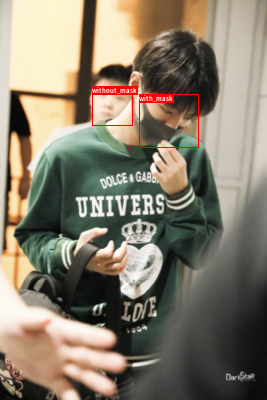

In [28]:
visualize_boxes(x, t)

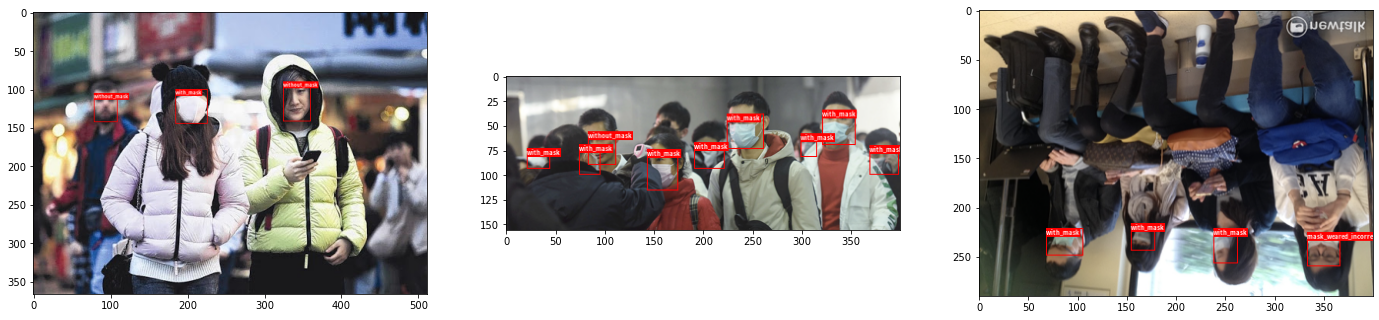

In [29]:
plt.figure(figsize = (24, 12))
for i in range(3):
    x, t = dataset1[i]
    image = visualize_boxes(x, t)
    plt.subplot(1, 3, i + 1)
    plt.imshow(image)

In [30]:
train1, val1, test1 = torch.utils.data.random_split(dataset = dataset1, lengths = [752, 40, 50], generator = torch.Generator().manual_seed(4))

In [31]:
len(train1), len(val1), len(test1)

(752, 40, 50)

In [32]:
def collate_fn(batch):
    return list(zip(* batch))

batch_size = 8

train_loader = torch.utils.data.DataLoader(train1, batch_size, shuffle = False, drop_last = True, collate_fn = collate_fn)

In [33]:
x, t = next(iter(train_loader))

In [34]:
x

(tensor([[[0.3922, 0.3843, 0.3961,  ..., 0.5922, 0.5922, 0.5843],
          [0.4039, 0.3922, 0.4078,  ..., 0.5922, 0.5882, 0.5843],
          [0.4078, 0.4000, 0.4000,  ..., 0.5882, 0.5882, 0.5765],
          ...,
          [0.0549, 0.0275, 0.0275,  ..., 0.3686, 0.3608, 0.3569],
          [0.0549, 0.0235, 0.0235,  ..., 0.3725, 0.3686, 0.3490],
          [0.0863, 0.0549, 0.0588,  ..., 0.3922, 0.3725, 0.3647]],
 
         [[0.3647, 0.3608, 0.3686,  ..., 0.5961, 0.5961, 0.5882],
          [0.3765, 0.3686, 0.3804,  ..., 0.5961, 0.5922, 0.5882],
          [0.3843, 0.3725, 0.3765,  ..., 0.5922, 0.5922, 0.5804],
          ...,
          [0.0627, 0.0353, 0.0353,  ..., 0.3804, 0.3725, 0.3686],
          [0.0627, 0.0314, 0.0314,  ..., 0.3843, 0.3804, 0.3608],
          [0.0902, 0.0588, 0.0627,  ..., 0.4000, 0.3843, 0.3804]],
 
         [[0.3176, 0.3176, 0.3255,  ..., 0.6196, 0.6196, 0.6078],
          [0.3333, 0.3216, 0.3333,  ..., 0.6157, 0.6157, 0.6118],
          [0.3412, 0.3255, 0.3294,  ...,

In [35]:
len(x)

8

In [36]:
t

({'boxes': tensor([[156.,  54., 254., 163.],
          [ 35., 170.,  90., 223.],
          [234.,  17., 294.,  96.]]),
  'labels': tensor([2, 2, 1]),
  'image_id': tensor([349]),
  'area': tensor([10682.,  2915.,  4740.]),
  'iscrowd': tensor([0, 0, 0])},
 {'boxes': tensor([[148., 130., 176., 161.],
          [233., 126., 261., 155.],
          [ 43., 138.,  62., 160.],
          [108., 115., 131., 137.],
          [288., 116., 303., 138.],
          [318., 133., 336., 151.],
          [365., 129., 382., 148.],
          [188., 132., 199., 147.]]),
  'labels': tensor([2, 2, 1, 1, 1, 1, 1, 1]),
  'image_id': tensor([570]),
  'area': tensor([868., 812., 418., 506., 330., 324., 323., 165.]),
  'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0])},
 {'boxes': tensor([[ 66.,  75., 105., 115.],
          [177.,  91., 202., 116.],
          [152.,  65., 175.,  90.],
          [251.,  85., 281., 115.]]),
  'labels': tensor([2, 2, 2, 2]),
  'image_id': tensor([278]),
  'area': tensor([1560.,  625.,  575

In [37]:
type(x)

tuple

# Create Dataset without Data Augmentation for Validation and Test

In [38]:
class MaskDataset(torch.utils.data.Dataset):

    def __init__(self, root):
        self.root = root
        self.mask_labels = ['BG', 'without_mask', 'with_mask', 'mask_weared_incorrect']
        self.imgs = list(sorted(os.listdir('/kaggle/input/face-mask-detection/images/')))
        # Add for data augmentation
        bbox_params = A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels'])
        self.transform = A.Compose([ToTensor()], bbox_params = bbox_params)
    

    def __getitem__(self, idx):
        data = 'maksssksksss' + str(idx)

        image_path = f'{self.root}/images/{data}.png'
        image = Image.open(image_path).convert('RGB')
        image = np.array(image)

        anno_path = f'{self.root}/annotations/{data}.xml'
        parser = parse(anno_path)
        labels, boxes = [], []
        for obj in parser.findall('object'):
            bndbox = obj.find('bndbox') # Add
            if bndbox.find('xmin').text != bndbox.find('xmax').text: # Add
                box = [int(tag.text) for tag in obj.find('bndbox')]
                label = obj.find('name').text
                label = self.mask_labels.index(label)
                boxes.append(box)
                labels.append(label)
                
        transformed = self.transform(image = image, bboxes = boxes, class_labels = labels)
        image = transformed['image']
        boxes = torch.tensor(transformed['bboxes'], dtype = torch.float32)
        labels = torch.tensor(transformed['class_labels'], dtype = torch.int64)
        
        # Add for estimation of mean Average Precisions
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        image_id = torch.tensor([idx])
        iscrowd = torch.zeros((len(parser.findall('object')),), dtype = torch.int64)

        target = {'boxes': boxes, 'labels': labels, 'image_id': image_id, 'area': area, 'iscrowd': iscrowd}

        return image, target


    def __len__(self):
        return len(self.imgs)

In [39]:
pl.seed_everything(0)
root = '/kaggle/input/face-mask-detection'
dataset2 = MaskDataset(root)

In [40]:
dataset = []
removed = []
for i in range(len(dataset2)):
    if i in removed_list:
        removed.append(dataset2[i])
    else:
        dataset.append(dataset2[i])

In [41]:
len(dataset)

842

In [42]:
dataset2 = dataset

In [43]:
train2, val2, test2 = torch.utils.data.random_split(dataset = dataset2, lengths = [752, 40, 50], generator = torch.Generator().manual_seed(42))

In [44]:
len(train2), len(val2), len(test2)

(752, 40, 50)

## The removed data can be used for validation or test.

In [45]:
val = []
for i in range(len(val2)):
    val.append(val2[i])
for i in range(len(removed)):
    val.append(removed[i])
len(val)

51

In [46]:
val2 = val
len(val2)

51

In [47]:
def collate_fn(batch):
    return list(zip(* batch))

batch_size = 8

val_loader = torch.utils.data.DataLoader(val2, batch_size, collate_fn = collate_fn)
test_loader = torch.utils.data.DataLoader(test2, batch_size, collate_fn = collate_fn)

# Training, Validation, and Test with RetinaNet

In [48]:
import math
from torchvision.models.detection import retinanet_resnet50_fpn

In [49]:
class Net(pl.LightningModule):

    def __init__(self, n_class = 4):
        super().__init__()

        self.model = retinanet_resnet50_fpn(pretrained = True)
        self.num_anchors = self.model.head.classification_head.num_anchors

        self.model.head.classification_head.num_classes = n_class

        self.cls_logits = torch.nn.Conv2d(256, self.num_anchors * n_class, kernel_size = 3, stride = 1, padding = 1)
        torch.nn.init.normal_(self.cls_logits.weight, std = 0.01)  # RetinaNetClassificationHead
        torch.nn.init.constant_(self.cls_logits.bias, - math.log((1 - 0.01) / 0.01))  # RetinaNetClassificationHead
        self.model.head.classification_head.cls_logits = self.cls_logits

        for p in self.model.parameters():
            p.requires_grad = False

        for p in self.model.head.classification_head.parameters():
            p.requires_grad = True

        for p in self.model.head.regression_head.parameters():
            p.requires_grad = True

        self.model.cuda()

    def forward(self, x, t = None):
        if self.training:
            return self.model(x, t)
        else:
            return self.model(x)


    def training_step(self, batch, batch_idx):
        x, t = batch
        losses = self(x, t)
        loss = sum(losses.values())
        self.log('train_loss', loss, on_step = True, on_epoch = True, prog_bar = True)
        return loss


    def validation_step(self, batch, batch_idx):
        x, t = batch
        losses = self.train().forward(x, t)
        loss = sum(losses.values())
        self.log('val_loss', loss, on_step = False, on_epoch = True)


    def test_step(self, batch, batch_idx):
        x, t = batch
        losses = self.train().forward(x, t)
        loss = sum(losses.values())
        self.log('test_loss', loss, on_step = False, on_epoch = True)


    def configure_optimizers(self):
        params = [p for p in self.model.parameters() if p.requires_grad]
        optimizer = torch.optim.Adam(params)
        return optimizer

In [50]:
pl.seed_everything(0)
net = Net()
trainer = pl.Trainer(max_epochs = 30, gpus = 1, deterministic = True)
trainer.fit(net, train_loader, val_loader)

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth


  0%|          | 0.00/130M [00:00<?, ?B/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:468: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/data.py:85: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [51]:
trainer.test(dataloaders = test_loader)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:128: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  + f" You can pass `.{fn}(ckpt_path='best')` to use the best model or"


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.21658790111541748    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.21658790111541748}]

In [52]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

# Visualize the Results

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageDraw, ImageFont

In [54]:
%%capture
!if [ ! -d fonts ]; then mkdir fonts && cd fonts && wget https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKjp-hinted.zip && unzip NotoSansCJKjp-hinted.zip && cd .. ;fi

In [55]:
def visualize_results(input, output):

    mask_labels = ['BG', 'without_mask', 'with_mask', 'mask_weared_incorrect']

    image = input.permute(1, 2, 0).numpy()
    image = Image.fromarray((image * 255).astype(np.uint8))

    boxes = output['boxes'].cpu().detach().numpy()
    labels = output['labels'].cpu().detach().numpy()

    if 'scores' in output.keys():
        scores = output['scores'].cpu().detach().numpy()
        boxes = boxes[scores > 0.5]
        labels = labels[scores > 0.5]

    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype('fonts/NotoSansCJKjp-Bold.otf', 6)
    for box, label in zip(boxes, labels):
        # box
        draw.rectangle(box, outline = 'red')
        # label
        text = mask_labels[label]
        w, h = font.getsize(text)
        draw.rectangle([box[0], box[1], box[0] + w, box[1] + h], fill = 'red')
        draw.text((box[0], box[1]), text, font = font, fill = 'white')

    return image

In [56]:
net.cpu().eval()
x, t = test2[0]
y = net(x.unsqueeze(0))[0]

In [57]:
x

tensor([[[0.2314, 0.1529, 0.0784,  ..., 0.3804, 0.3804, 0.3647],
         [0.2000, 0.1137, 0.0980,  ..., 0.3686, 0.3765, 0.3725],
         [0.1725, 0.0902, 0.1020,  ..., 0.3725, 0.3843, 0.3804],
         ...,
         [0.1333, 0.1490, 0.1490,  ..., 0.5373, 0.5373, 0.5294],
         [0.1255, 0.1490, 0.1529,  ..., 0.5333, 0.5333, 0.5294],
         [0.1176, 0.1333, 0.1412,  ..., 0.5333, 0.5333, 0.5294]],

        [[0.3216, 0.2196, 0.1608,  ..., 0.4510, 0.4510, 0.4431],
         [0.3020, 0.2118, 0.1490,  ..., 0.4392, 0.4549, 0.4549],
         [0.2863, 0.1804, 0.1451,  ..., 0.4510, 0.4667, 0.4627],
         ...,
         [0.2314, 0.2549, 0.2588,  ..., 0.5922, 0.5922, 0.5843],
         [0.2275, 0.2471, 0.2588,  ..., 0.5961, 0.5961, 0.5922],
         [0.2078, 0.2314, 0.2431,  ..., 0.5961, 0.5961, 0.5922]],

        [[0.2941, 0.2118, 0.1490,  ..., 0.4078, 0.4196, 0.4118],
         [0.2784, 0.1882, 0.1490,  ..., 0.3961, 0.4196, 0.4235],
         [0.2627, 0.1647, 0.1451,  ..., 0.4078, 0.4275, 0.

In [58]:
t

{'boxes': tensor([[124.,  48., 143.,  96.],
         [201.,  89., 235., 121.],
         [226.,  15., 271.,  66.]]),
 'labels': tensor([1, 1, 2]),
 'image_id': tensor([189]),
 'area': tensor([ 912., 1088., 2295.]),
 'iscrowd': tensor([0, 0, 0])}

In [59]:
y

{'boxes': tensor([[224.0893,  15.0026, 270.8612,  67.1740],
         [200.5162,  89.3852, 234.0135, 122.1997],
         [120.8800,  49.5632, 142.7722,  95.5075],
         [102.3786,  57.3293, 141.2311, 104.3585],
         [118.4827,  62.3634, 144.9248, 107.3774],
         [124.7796,  42.5960, 145.7719,  83.5098],
         [226.2716,  20.0530, 259.3828,  55.0798],
         [121.2602,  46.6945, 147.8665,  87.4753],
         [202.0153,  77.4578, 236.9910, 111.2015],
         [115.5392,  54.9875, 144.7229,  97.4938],
         [210.2730,  82.3101, 242.0621, 121.9330],
         [227.2349,  38.4253, 258.0812,  68.4238],
         [213.4282,  89.2884, 234.2563, 115.8151],
         [ 77.8830,  51.2362, 140.3091, 113.8387],
         [108.9878,  54.7503, 142.9713,  86.0788],
         [127.1824,  60.5510, 142.5701,  93.0067],
         [131.5186,  66.7067, 159.9331,  93.4699],
         [119.1418,  53.1131, 142.5176, 100.4938],
         [ 68.6977,  55.8610, 107.9626,  94.5634],
         [202.2832,  8

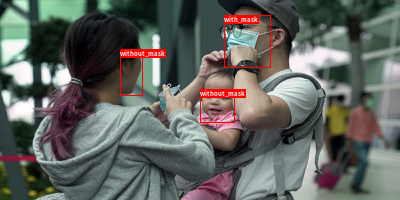

In [60]:
visualize_results(x, y)

In [61]:
x, t = test2[1]
y = net(x.unsqueeze(0))[0]

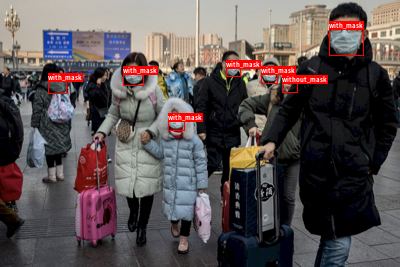

In [62]:
visualize_results(x, y)

# Non-Maximum Suppression (NMS) to Select the Best Boxes

In [63]:
from torchvision.ops import batched_nms

In [64]:
keep = batched_nms(boxes = y['boxes'], scores = y['scores'], idxs = y['labels'], iou_threshold = 0.2)
keep

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  12,  18,  19,
         20,  24,  25,  26,  27,  29,  30,  31,  32,  34,  35,  36,  37,  38,
         40,  41,  42,  45,  50,  51,  55,  57,  59,  61,  63,  65,  66,  67,
         72,  73,  74,  75,  77,  78,  79,  81,  82,  86,  88,  92,  95,  98,
        103, 104, 105, 106, 109, 115, 118, 119, 120, 122, 128, 131, 135, 136,
        139, 143, 144, 149, 150, 157, 158, 159, 160, 162])

In [65]:
y['boxes'][keep]

tensor([[123.4376,  66.2904, 143.5031,  85.3186],
        [329.1458,  21.7394, 363.0047,  55.4360],
        [261.1289,  66.1884, 277.8035,  83.7801],
        [226.6041,  60.1099, 240.1599,  76.0956],
        [282.2563,  75.0047, 297.0816,  92.2510],
        [168.4109, 113.8908, 184.1986, 130.8891],
        [ 48.1143,  73.2266,  66.7643,  93.9016],
        [268.8645,  83.8608, 279.4108, 104.7191],
        [223.5050,  59.0967, 239.6461,  75.5218],
        [195.2639,  72.6841, 204.6430,  81.6807],
        [254.0960,  68.6941, 261.1225,  77.8751],
        [ 30.8962,  73.1404,  38.5603,  82.0140],
        [201.8047,  69.8094, 209.2862,  81.3473],
        [221.3397,  58.4841, 229.4065,  70.9466],
        [ 90.7655,  74.7982,  96.8415,  84.2064],
        [178.3772,  64.1113, 185.2913,  72.8676],
        [ 28.1057,  75.4822,  32.2297,  81.6941],
        [188.4664,  70.2832, 197.6023,  81.0345],
        [ 29.6956,  74.7066,  35.8235,  79.4864],
        [134.0916,  82.1902, 155.8794,  99.9682],


In [66]:
y['scores'][keep]

tensor([1.0000, 0.9999, 0.9960, 0.9928, 0.9680, 0.8561, 0.7113, 0.3899, 0.3487,
        0.3460, 0.2570, 0.2280, 0.1809, 0.1772, 0.1741, 0.1547, 0.1437, 0.1435,
        0.1422, 0.1330, 0.1330, 0.1316, 0.1302, 0.1254, 0.1240, 0.1236, 0.1205,
        0.1202, 0.1177, 0.1176, 0.1174, 0.1156, 0.1118, 0.1106, 0.1096, 0.1056,
        0.1049, 0.1019, 0.1015, 0.0989, 0.0988, 0.0983, 0.0906, 0.0895, 0.0883,
        0.0883, 0.0874, 0.0873, 0.0872, 0.0863, 0.0853, 0.0839, 0.0838, 0.0822,
        0.0820, 0.0796, 0.0776, 0.0776, 0.0774, 0.0771, 0.0752, 0.0733, 0.0728,
        0.0727, 0.0725, 0.0720, 0.0707, 0.0704, 0.0692, 0.0689, 0.0682, 0.0674,
        0.0674, 0.0651, 0.0649, 0.0625, 0.0595, 0.0567, 0.0540, 0.0534],
       grad_fn=<IndexBackward0>)

In [67]:
y['labels'][keep]

tensor([2, 2, 2, 2, 1, 2, 2, 1, 3, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2,
        1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 3, 1, 1, 2, 2, 1, 3, 2, 2, 2, 2, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 1, 3, 2, 1, 3, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 3, 2,
        1, 1, 1, 3, 1, 2, 1, 1])

In [68]:
y_nms = {'boxes': y['boxes'][keep], 'labels': y['labels'][keep], 'scores': y['scores'][keep]}
y_nms

{'boxes': tensor([[123.4376,  66.2904, 143.5031,  85.3186],
         [329.1458,  21.7394, 363.0047,  55.4360],
         [261.1289,  66.1884, 277.8035,  83.7801],
         [226.6041,  60.1099, 240.1599,  76.0956],
         [282.2563,  75.0047, 297.0816,  92.2510],
         [168.4109, 113.8908, 184.1986, 130.8891],
         [ 48.1143,  73.2266,  66.7643,  93.9016],
         [268.8645,  83.8608, 279.4108, 104.7191],
         [223.5050,  59.0967, 239.6461,  75.5218],
         [195.2639,  72.6841, 204.6430,  81.6807],
         [254.0960,  68.6941, 261.1225,  77.8751],
         [ 30.8962,  73.1404,  38.5603,  82.0140],
         [201.8047,  69.8094, 209.2862,  81.3473],
         [221.3397,  58.4841, 229.4065,  70.9466],
         [ 90.7655,  74.7982,  96.8415,  84.2064],
         [178.3772,  64.1113, 185.2913,  72.8676],
         [ 28.1057,  75.4822,  32.2297,  81.6941],
         [188.4664,  70.2832, 197.6023,  81.0345],
         [ 29.6956,  74.7066,  35.8235,  79.4864],
         [134.0916,  8

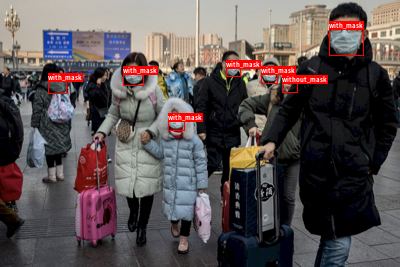

In [69]:
visualize_results(x, y_nms)

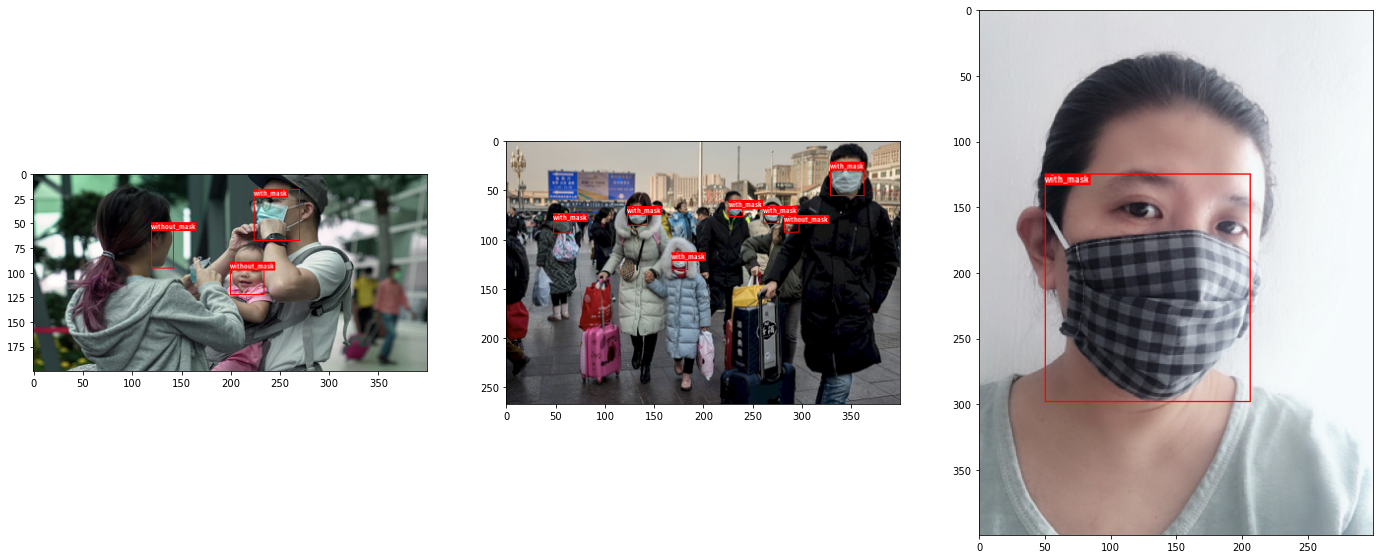

In [70]:
plt.figure(figsize = (24, 12))
net.eval()
for i in range(3):
    x, t = test2[i]
    y = net(x.unsqueeze(0))[0]
    keep = batched_nms(boxes = y['boxes'], scores = y['scores'], idxs = y['labels'], iou_threshold = 0.2)
    y_nms = {'boxes': y['boxes'][keep], 'labels': y['labels'][keep], 'scores': y['scores'][keep]}
    image = visualize_results(x, y_nms)
    plt.subplot(1, 3, i + 1)
    plt.imshow(image)

# Calculate Mean Average Precision (mAP)

In [71]:
%%capture
!if [ ! -d vision ]; then git clone https://github.com/pytorch/vision.git && cd vision && cp references/detection/utils.py ../ && cp references/detection/transforms.py ../ && cp references/detection/coco_eval.py ../ && cp references/detection/engine.py ../ && cp references/detection/coco_utils.py ../; fi

In [72]:
!ls

__notebook__.ipynb  coco_utils.py  fonts	   transforms.py  vision
coco_eval.py	    engine.py	   lightning_logs  utils.py


In [73]:
pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-xexg20y_
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-xexg20y_
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... - done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=371225 sha256=6ddf0c12408d5dff480a713a4ec56ecee2c09481b02b3fc814cee1059f954792
  Stored in directory: /tmp/pip-ephem-wheel-cache-mdx4nsud/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
Note: you may need to restart the kernel to use updated packages.


In [74]:
from engine import evaluate

In [75]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [76]:
pl.seed_everything(0)
net.to(device)
evaluate(net, test_loader, device)

creating index...
index created!
Test:  [0/7]  eta: 0:00:07  model_time: 1.0478 (1.0478)  evaluator_time: 0.0629 (0.0629)  time: 1.1144  data: 0.0004  max mem: 4112
Test:  [6/7]  eta: 0:00:00  model_time: 0.8248 (0.7948)  evaluator_time: 0.0467 (0.0512)  time: 0.8499  data: 0.0009  max mem: 4112
Test: Total time: 0:00:05 (0.8503 s / it)
Averaged stats: model_time: 0.8248 (0.7948)  evaluator_time: 0.0467 (0.0512)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.625
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.928
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.740
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.597
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.744
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.755
 Average Recall     (AR) @[ IoU=0.50

# Save the Model

In [77]:
torch.save(net.model, 'object_detection_facemask_pred_model.pth')

In [78]:
saved_model = torch.load('/kaggle/working/object_detection_facemask_pred_model.pth')

In [79]:
saved_model

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)
